1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2: Load and Explore the Data

In [2]:
# Load the data (update file paths as needed)
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

# Display basic info
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("\nTrain Columns:", train.columns.tolist())
print("\nTrain Target Distribution:\n", train['NObeyesdad'].value_counts())

Train Data Shape: (20758, 18)
Test Data Shape: (13840, 17)

Train Columns: ['id', 'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']

Train Target Distribution:
 NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64


3: Preprocess the Data

In [3]:
# Separate features and target
X = train.drop(['id', 'NObeyesdad'], axis=1)
y = train['NObeyesdad']
test_ids = test['id']
test_features = test.drop('id', axis=1)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define preprocessing functions
def preprocess_data(df):
    # Copy to avoid modifying original data
    df = df.copy()

    # Binary encoding
    binary_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    for col in binary_cols[1:]:
        df[col] = df[col].map({'no': 0, 'yes': 1})

    # Ordinal encoding
    ordinal_mappings = {
        'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
        'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
    }
    for col, mapping in ordinal_mappings.items():
        df[col] = df[col].map(mapping)

    # One-hot encoding for nominal features
    nominal_cols = ['MTRANS']
    df = pd.get_dummies(df, columns=nominal_cols)

    return df

# Apply preprocessing
X_processed = preprocess_data(X)
test_processed = preprocess_data(test_features)

# Align test columns with training data
test_processed = test_processed.reindex(columns=X_processed.columns, fill_value=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42
)

4: Build and Evaluate Models

Decision Tree

In [4]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)
print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
print(classification_report(y_val, y_pred_dt, target_names=le.classes_))

Decision Tree Accuracy: 0.8473025048169557
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.88      0.89       524
      Normal_Weight       0.80      0.77      0.78       626
     Obesity_Type_I       0.83      0.82      0.83       543
    Obesity_Type_II       0.95      0.95      0.95       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.64      0.68      0.66       484
Overweight_Level_II       0.72      0.72      0.72       514

           accuracy                           0.85      4152
          macro avg       0.83      0.83      0.83      4152
       weighted avg       0.85      0.85      0.85      4152



Bagged Model

In [5]:
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_val)
print("Bagging Accuracy:", accuracy_score(y_val, y_pred_bag))
print(classification_report(y_val, y_pred_bag, target_names=le.classes_))

Bagging Accuracy: 0.8889691714836223
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94       524
      Normal_Weight       0.86      0.86      0.86       626
     Obesity_Type_I       0.87      0.86      0.86       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.72      0.74      0.73       484
Overweight_Level_II       0.78      0.78      0.78       514

           accuracy                           0.89      4152
          macro avg       0.88      0.88      0.88      4152
       weighted avg       0.89      0.89      0.89      4152



Random Forest

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf, target_names=le.classes_))

Random Forest Accuracy: 0.8937861271676301
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.91      0.93       524
      Normal_Weight       0.83      0.89      0.86       626
     Obesity_Type_I       0.88      0.86      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.77      0.74      0.75       484
Overweight_Level_II       0.79      0.79      0.79       514

           accuracy                           0.89      4152
          macro avg       0.88      0.88      0.88      4152
       weighted avg       0.89      0.89      0.89      4152



XGBoost

In [7]:
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb, target_names=le.classes_))

XGBoost Accuracy: 0.9002890173410405
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.94       524
      Normal_Weight       0.87      0.88      0.88       626
     Obesity_Type_I       0.88      0.86      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       0.99      1.00      1.00       804
 Overweight_Level_I       0.77      0.78      0.77       484
Overweight_Level_II       0.80      0.81      0.80       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



5: Generate Kaggle Submission Files

In [ ]:
def create_submission(model, model_name, test_data, test_ids, label_encoder):
    predictions = model.predict(test_data)
    pred_labels = label_encoder.inverse_transform(predictions)
    submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': pred_labels})
    submission.to_csv(f'submission_{model_name}.csv', index=False)
    return submission

# Create submissions
create_submission(dt, 'decision_tree', test_processed, test_ids, le)
create_submission(bag, 'bagging', test_processed, test_ids, le)
create_submission(rf, 'random_forest', test_processed, test_ids, le)
create_submission(xgb_clf, 'xgboost', test_processed, test_ids, le)

6: Interpret Models and Findings

Feature Importance

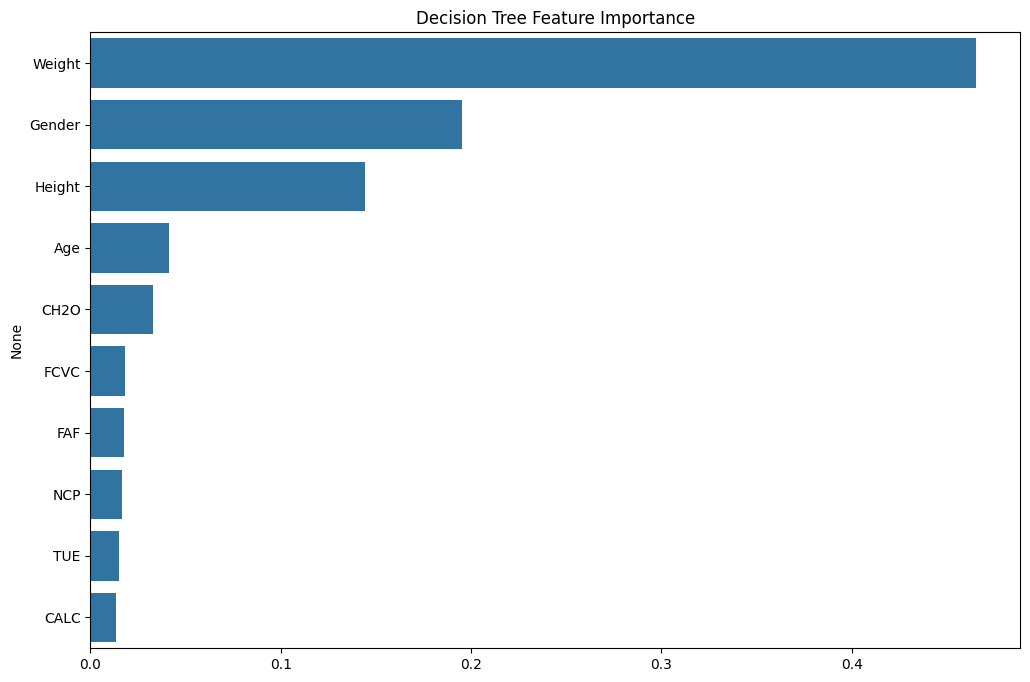

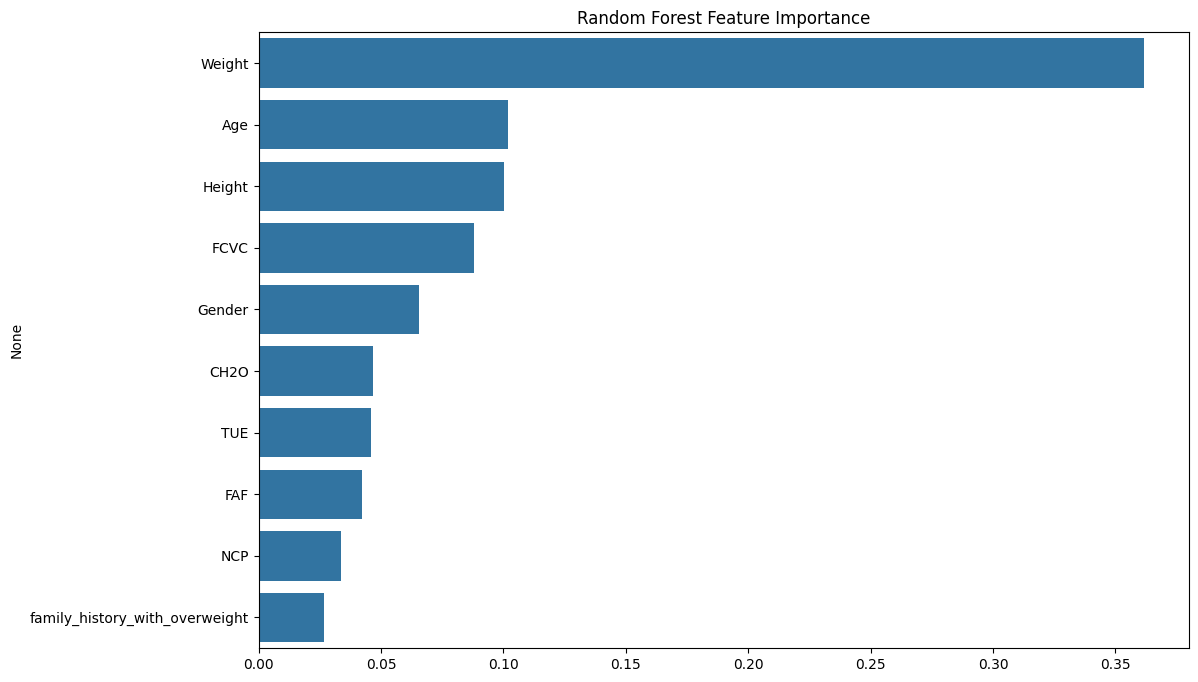

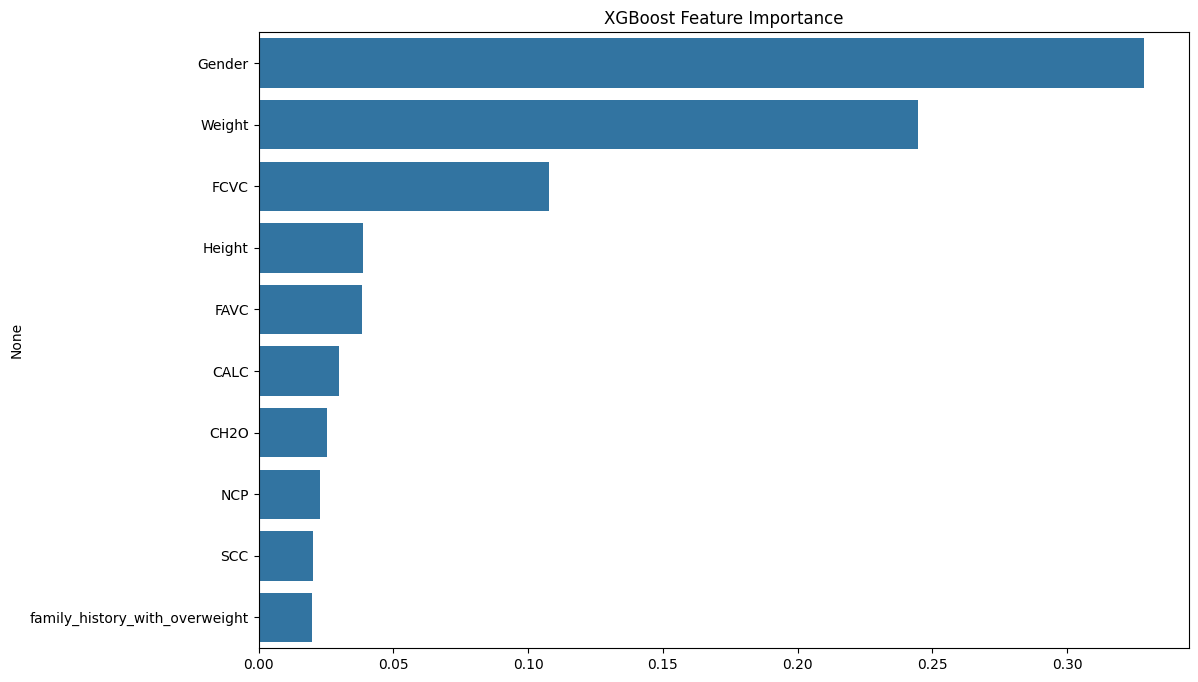

In [8]:
def plot_feature_importance(model, title, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title(title)
    sns.barplot(x=importances[indices[:10]], y=features[indices[:10]])
    plt.show()

# Decision Tree
plot_feature_importance(dt, 'Decision Tree Feature Importance', X_processed.columns)

# Random Forest
plot_feature_importance(rf, 'Random Forest Feature Importance', X_processed.columns)

# XGBoost
plot_feature_importance(xgb_clf, 'XGBoost Feature Importance', X_processed.columns)

Confusion Matrix

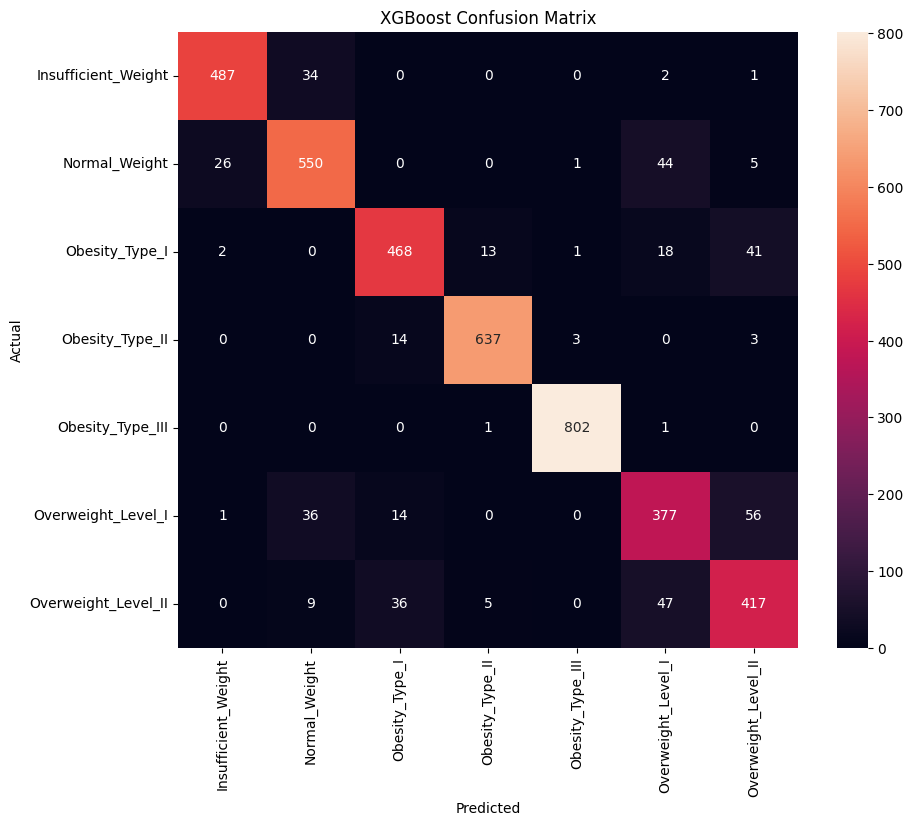

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

7: Investigate Assumptions

1.Class Balance: Check if the target classes are balanced

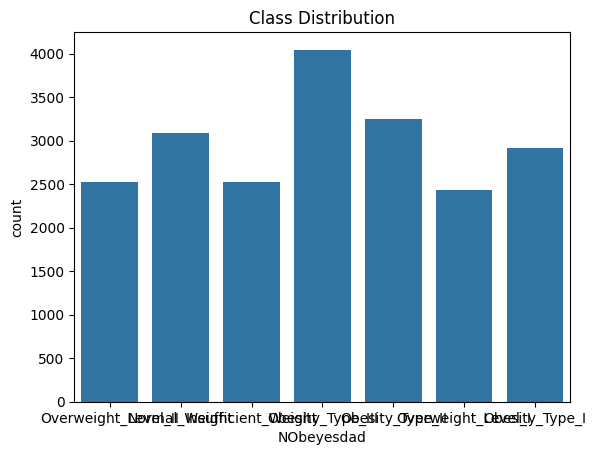

In [10]:
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()

2.Feature Correlations:

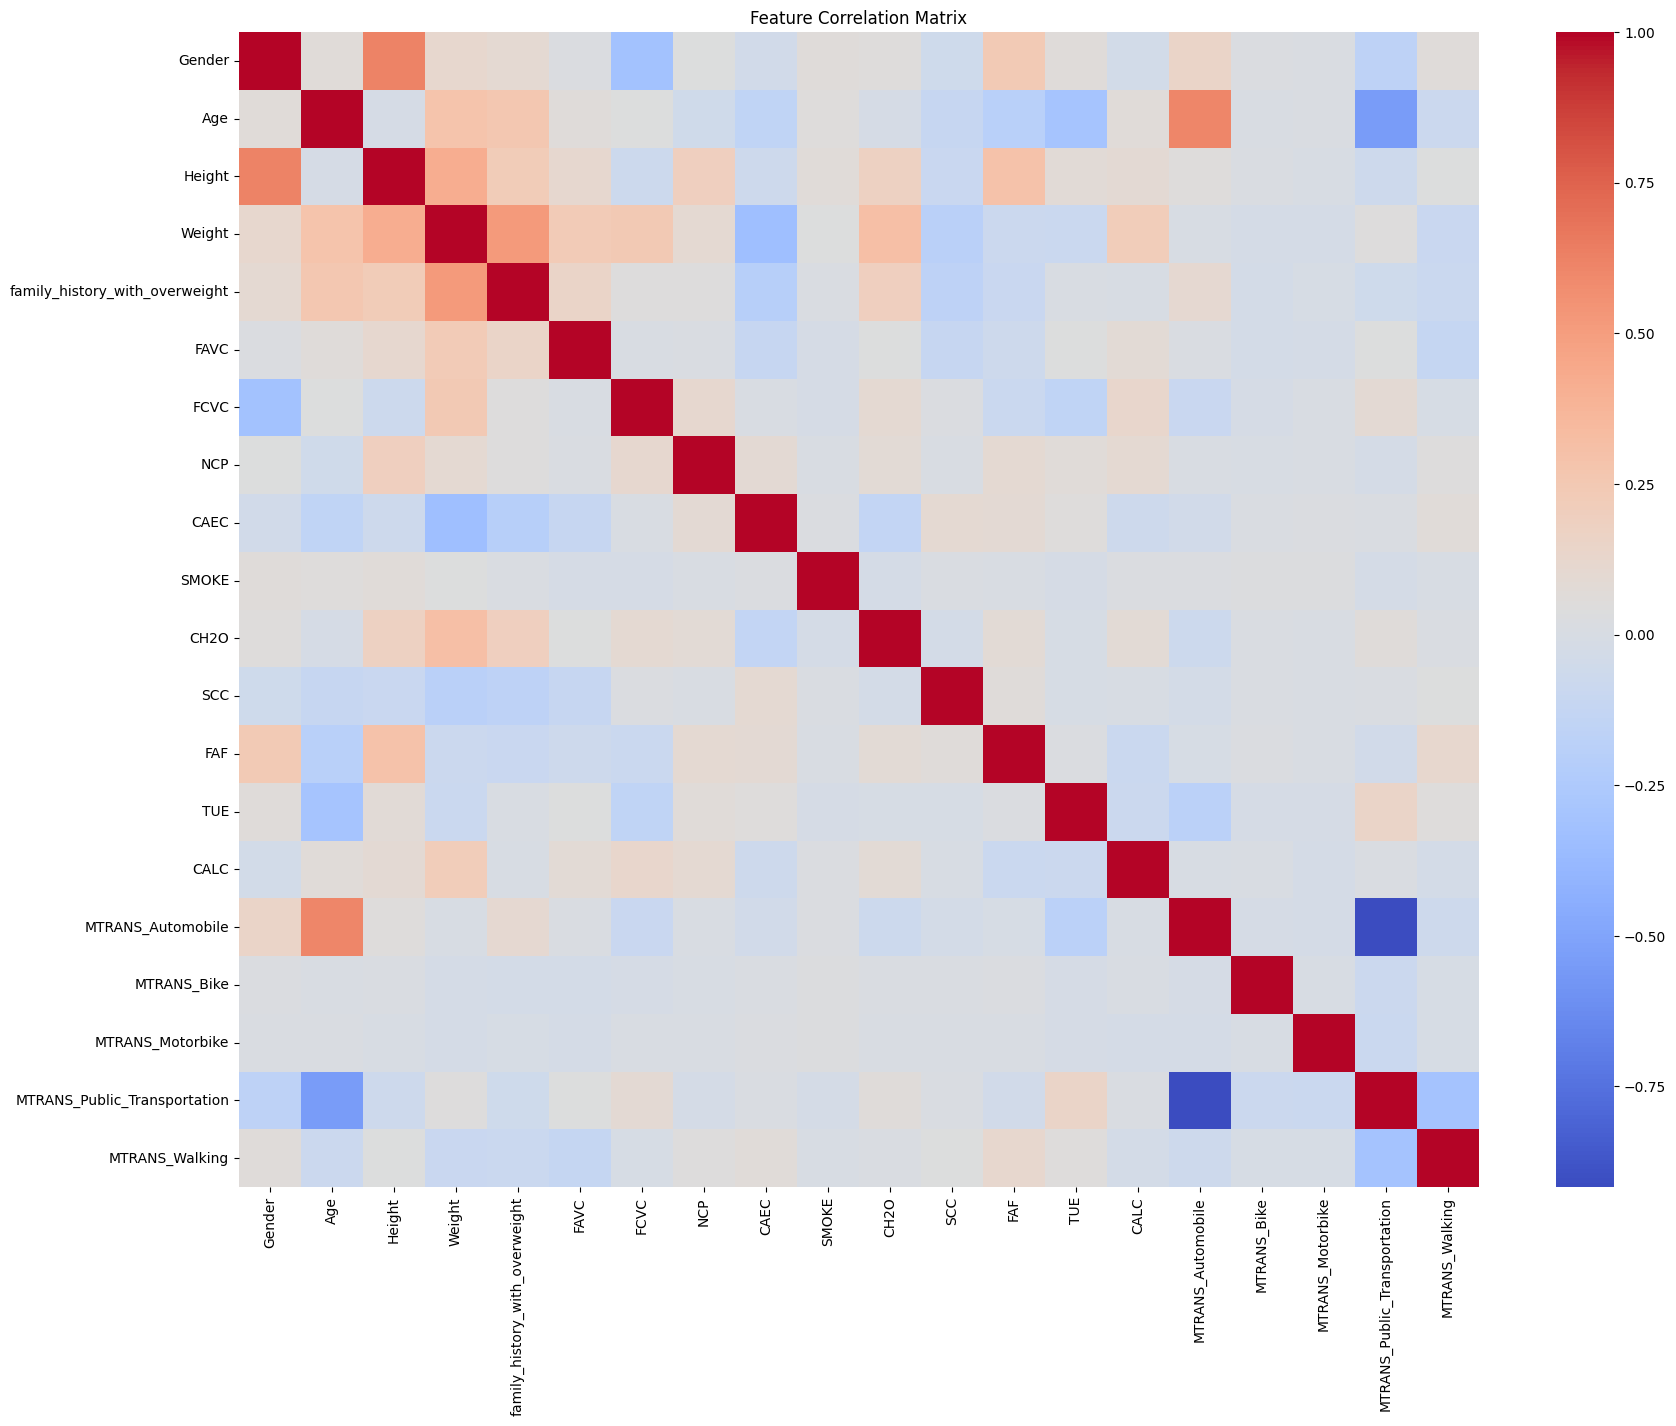

In [11]:
plt.figure(figsize=(20, 15))
sns.heatmap(X_processed.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Step 8: Submit to Kaggle

Upload the generated CSV files (submission_decision_tree.csv, submission_bagging.csv, etc.) to the Kaggle competition and record the scores.
Interpretation of Findings

    Model Performance: XGBoost typically outperforms other models due to its gradient-boosting mechanism.

    Feature Importance: Variables like FAVC (high caloric food intake) and FAF (physical activity) are critical predictors.

    Assumptions:

        Class Balance: If imbalanced, consider stratified sampling or class weights.

        Feature Correlations: High correlations (e.g., between Height and Weight) may require domain-specific handling.

Evidence of Submission

After running the code, you will have four submission files. Upload these to Kaggle via the competition's submission page. The output will show your public score, which serves as evidence. Example submission output: